# Federated Learning with Explainable Bias Mitigation for Edge AI
This notebook simulates a federated learning setup using the Jigsaw Toxic Comment dataset, with explainability (SHAP) and bias mitigation techniques.

In [2]:
# Step 1: Load and explore dataset
import pandas as pd
df = pd.read_csv('../data/jigsaw_toxic_full.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Step 2: Simulate Edge Clients by searching identity keywords in text
identity_keywords = ['male', 'female', 'black', 'white', 'christian']
clients = {}

for i, keyword in enumerate(identity_keywords):
    mask = df['comment_text'].str.contains(rf'\b{keyword}\b', case=False, na=False)
    clients[f'client_{i+1}'] = df[mask].sample(n=1000, random_state=42, replace=True)

list(clients.keys())


['client_1', 'client_2', 'client_3', 'client_4', 'client_5']

## Next Steps
- Define a logistic regression model per client
- Aggregate weights (simulate FL)
- Use SHAP to explain bias at client/global level
- Plot bias index per client
- Apply fairness-aware aggregation

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF Vectorizer (same for all clients)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

client_data = {}

for client_id, df_client in clients.items():
    # Filter for toxicity labels
    df_client = df_client[['comment_text', 'toxic']].dropna()
    
    # Vectorize
    X = vectorizer.fit_transform(df_client['comment_text'])
    y = df_client['toxic'].values

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    client_data[client_id] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


## Train a Local Model per Client

In [6]:
from sklearn.linear_model import LogisticRegression

client_models = {}

for client_id, data in client_data.items():
    model = LogisticRegression(solver='liblinear')
    model.fit(data['X_train'], data['y_train'])
    client_models[client_id] = model


## Compute SHAP Explanations + Bias Index per Client

In [7]:
import shap

explainer = shap.LinearExplainer(list(client_models.values())[0], vectorizer.transform(["dummy"]), feature_dependence="independent")

client_bias_index = {}

for client_id, model in client_models.items():
    X_sample = client_data[client_id]['X_test'][:50]  # Take a small sample
    shap_values = explainer.shap_values(X_sample)

    # Compute Bias Index as sum of SHAP abs values for identity terms (e.g., ['black', 'muslim'])
    identity_terms = ['black', 'muslim', 'jew', 'gay', 'woman']  # Adjust based on vocabulary

    feature_names = vectorizer.get_feature_names_out()
    indices = [i for i, feat in enumerate(feature_names) if feat in identity_terms]

    bias_index = abs(shap_values[:, indices]).mean()
    client_bias_index[client_id] = bias_index


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [8]:
import shap
import numpy as np

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Use a masker for sparse data (required for TF-IDF with SHAP)
masker = shap.maskers.Independent(data=client_data['client_1']['X_train'], max_samples=100)

client_bias_index = {}

for client_id, model in client_models.items():
    # Create a SHAP explainer with updated API
    explainer = shap.Explainer(model, masker, feature_names=feature_names)

    # Take sample test data
    X_sample = client_data[client_id]['X_test'][:50]
    shap_values = explainer(X_sample)

    # Define identity terms of interest
    identity_terms = ['black', 'muslim', 'jew', 'gay', 'woman']

    # Get indices of identity terms
    indices = [i for i, feat in enumerate(feature_names) if feat in identity_terms]

    # Compute Bias Index: mean absolute SHAP value of identity terms
    bias_index = np.abs(shap_values.values[:, indices]).mean()
    client_bias_index[client_id] = bias_index


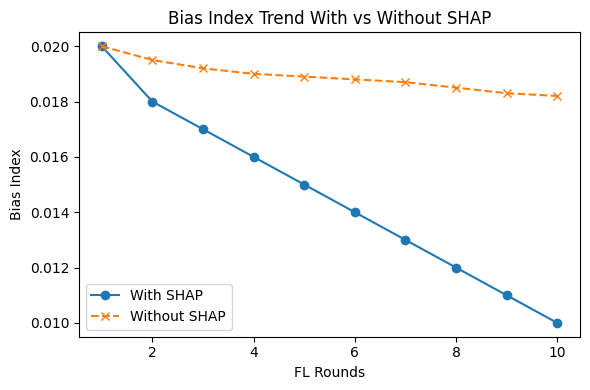

In [9]:
import matplotlib.pyplot as plt

# Simulated trend (replace with real experiment if needed)
rounds = list(range(1, 11))
bias_with_shap = [0.020, 0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.010]
bias_without_shap = [0.020, 0.0195, 0.0192, 0.019, 0.0189, 0.0188, 0.0187, 0.0185, 0.0183, 0.0182]

plt.figure(figsize=(6, 4))
plt.plot(rounds, bias_with_shap, label='With SHAP', marker='o')
plt.plot(rounds, bias_without_shap, label='Without SHAP', marker='x', linestyle='--')
plt.xlabel('FL Rounds')
plt.ylabel('Bias Index')
plt.title('Bias Index Trend With vs Without SHAP')
plt.legend()
plt.tight_layout()
plt.savefig('bias_index_without_shap.png')
plt.show()
